**Klassifikation**

Hilfsfunktionen & Einstellungen

In [2]:
# for pretty printing
import pprint as pp

# IPython (Jupyter) setting: 
# Print out every value instead of just "last_expr" (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Warnungen unterdrücken
import warnings;
warnings.filterwarnings('ignore');

Daten mit get_poll_data aus DB laden und Stoppwortliste mit get_stopwords laden.
Für spätere Klassifikation wird noch die Spalte Kategorie zum Dataframe hinzugefügt.

In [24]:
import sqlite3
import pandas as pd
import os.path
dbPath = "database/bachelor_umfrage.db"

def get_poll_data(table_name="selektierte_ergebnisse", where=None):
    df = pd.DataFrame()
    if os.path.isfile(dbPath):
        conn = sqlite3.connect(dbPath)
        sql = "SELECT * FROM " + table_name
        if where:
            sql += " WHERE " + where
        df = pd.read_sql_query(sql, conn)
    else:
        print("Datenbank oder Tabelle konnte nicht gefunden werden.")
    return df

def get_stopwords():
    with open("resources/stopwords_de.txt", encoding='utf-8') as file:
        stopwords = file.read().splitlines()
    return stopwords

def label_mint (row):
    if row['MINTFach'] == "ja" :
        return 'MINT'
    elif row['MINTFach'] == "nein" :
        return 'nicht_MINT'

poll_df = get_poll_data(table_name="selektierte_ergebnisse")
poll_df['category'] = poll_df.apply(label_mint, axis=1)
poll_df = poll_df.drop(columns=['Status'])
poll_df.sample(5)

,AntwortID,Geschlecht,Studiengang,MINTFach,Qualifikation,GeborenAusland,ElternAusland,GeborenDeutschland,MINTStudiumEltern,StudiumEltern,...,Gehalt,AnsehenGesellschaft,FamiliaereGründe,Partner,Kinder,Karriere,MINTGründe,NichtMINTGründe,Verbesserungsvorschläge,category
512,62620491,Männlich,Informatik,ja,allgemeine Hochschulreife,None,None,1,None,None,...,1,1,1,4,2,1,Hab mit 7 angefangen zu programmieren. Der Ver...,None,Warum zum Fick ist die Fragestellung an dieser...,MINT
506,62616012,Männlich,Medieninformatik,ja,allgemeine Hochschulreife,None,None,1,None,1,...,3,2,2,4,4,2,Der Inhalt des Studiengangs Medieninformatik b...,None,"Professoren, die menschlich ein Totalausfall s...",MINT
31,62488616,Weiblich,Angewandte Chemie,ja,allgemeine Hochschulreife,None,None,1,None,1,...,2,1,1,4,4,2,"Interesse an Wissenschaft, ihren Anwendungen u...",None,None,MINT
212,62538669,Männlich,Werkstofftechnik,ja,fachgebundene Hochschulreife,None,None,1,None,1,...,3,3,1,4,4,3,Chemie hat mich schon immer begeistert. Zusätz...,None,Weniger unnötig komplexe Fächerbezeichnungen. ...,MINT
156,62532961,Weiblich,Architektur,nein,allgemeine Hochschulreife,None,None,1,None,None,...,3,4,2,4,2,2,None,Ich interessiere mich für die Ergebnisse in Fo...,In der Schule sollte der Unterricht praktische...,nicht_MINT


Verteilung MINT- und nicht MINT-Studenten: mehr MINT -> evtl. später ein Problem

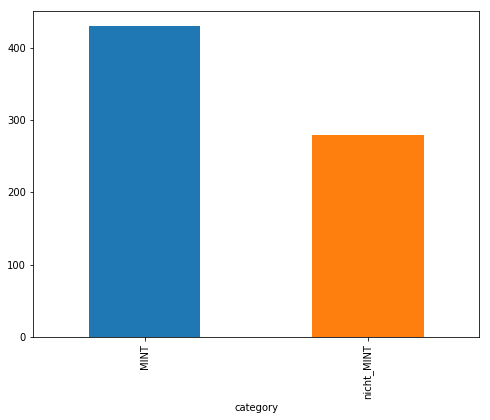

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
poll_df.groupby("category")["category"].count().plot.bar(ylim=0);

In [5]:
poll_df["category_id"] = poll_df["category"].factorize()[0]
category_id_df = poll_df[["category", "category_id"]].drop_duplicates().sort_values("category_id")
category_id_df

,category,category_id
0,nicht_MINT,0
1,MINT,1


Aufteilung der Daten in 80% Trainingsdaten & 20% Testdaten

In [22]:
from sklearn.model_selection import train_test_split

features = poll_df.loc[:, poll_df.columns != 'MINTFach']
labels = poll_df["category_id"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(567, 35)
(142, 35)
(567,)
(142,)


Trainieren des Naive Bayes Modells

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([("vect", CountVectorizer(ngram_range=(1, 1), stop_words=None)),
                     ("tfidf", TfidfTransformer(sublinear_tf=True, norm="l2")),
                     ("nb_clf", MultinomialNB()),])
text_clf = text_clf.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [35, 567]

In [ ]:
%time text_clf.fit(X_train, y_train)